<a href="https://colab.research.google.com/github/isaacdono/ml-studies/blob/main/deep%20learning/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo Prático: Transformers e o Mecanismo de Atenção

Os Transformers revolucionaram o Processamento de Linguagem Natural (PLN). Diferente das RNNs que processam texto sequencialmente, os Transformers o processam em paralelo. A inovação que permitiu isso foi o **Mecanismo de Atenção (Attention Mechanism)**, especificamente o **Self-Attention**.

**Objetivos deste notebook:**
1.  **Entender a Intuição:** Por que a atenção é necessária?
2.  **Construir do Zero:** Implementar um mecanismo de Self-Attention para entender seu funcionamento interno.
3.  **Usar na Prática:** Aplicar um modelo Transformer real (BERT) da biblioteca Hugging Face para uma tarefa e visualizar seus padrões de atenção.

## Parte 1: O Coração do Transformer - Self-Attention do Zero

Imagine a frase: "O robô pegou a bola porque **ela** era pesada". Para nós, é óbvio que "ela" se refere à "bola". Para um modelo, isso não é trivial. O Self-Attention permite que o modelo aprenda essas relações, calculando um "score de atenção" entre cada par de palavras na sentença.

Para isso, para cada palavra de entrada, criamos três vetores:
- **Query (Q)**: O que eu estou procurando? (Ex: "a que 'ela' se refere?")
- **Key (K)**: O que eu tenho a oferecer? (Ex: "eu sou a 'bola'")
- **Value (V)**: O que eu realmente sou. (A representação da palavra 'bola')

O processo é:
1.  Para uma palavra (Query), comparamos seu `Q` com o `K` de todas as outras palavras para encontrar `scores`.
2.  Normalizamos os `scores` com uma função `softmax` para obter pesos de atenção.
3.  Calculamos uma média ponderada dos vetores `Value` de todas as palavras, usando os pesos de atenção. O resultado é a nova representação da palavra, rica em contexto.

In [15]:
import numpy as np

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

# 1. Dados de Entrada: Vetores (embeddings) para 3 palavras
# Digamos que temos uma frase simples: "pense sobre máquinas"
# Cada palavra tem um embedding de dimensão 4.
embeddings = np.array([
    [1, 0, 1, 0], # pense
    [0, 1, 0, 1], # sobre
    [1, 1, 0, 1]  # máquinas
])
d_embedding = embeddings.shape[1]

# 2. Criar os vetores Q, K, V
# Na prática, são matrizes de pesos treináveis. Aqui, vamos defini-las aleatoriamente.
# A dimensão dos vetores Q, K, V (d_k) pode ser diferente da dimensão do embedding.
d_k = 3
np.random.seed(42)
W_query = np.random.rand(d_embedding, d_k)
W_key = np.random.rand(d_embedding, d_k)
W_value = np.random.rand(d_embedding, d_k)

# Calculando Q, K, V
Q = np.matmul(embeddings, W_query)
K = np.matmul(embeddings, W_key)
V = np.matmul(embeddings, W_value)

print("--- Vetores Q, K, V ---")
print("Q:\n", Q)
print("\nK:\n", K)
print("\nV:\n", V)

# 3. Calcular os Scores de Atenção
# scores = (Q * K^T) / sqrt(d_k)
scores = np.matmul(Q, K.T) / np.sqrt(d_k)
print("\n--- Scores Brutos (Antes do Softmax) ---\n", scores)

# 4. Obter os Pesos de Atenção (Softmax)
attention_weights = softmax(scores)
print("\n--- Pesos de Atenção (Após Softmax) ---\n", attention_weights.round(2))

# 5. Calcular a Saída Final
# A saída para cada palavra é a soma ponderada dos vetores V de todas as outras palavras.
output = np.matmul(attention_weights, V)
print("\n--- Saída Final (Representação Contextualizada) ---\n", output)

--- Vetores Q, K, V ---
Q:
 [[0.43262373 1.81689045 1.33310895]
 [1.30673106 0.17660313 1.12590437]
 [1.68127118 1.12731744 1.85789831]]

K:
 [[1.26438766 0.50356825 0.79367786]
 [0.32289837 0.59638689 0.89111827]
 [1.15534101 0.808726   1.07294324]]

V:
 [[1.06361484 0.95570009 0.26472538]
 [1.46311998 1.5580466  0.85484776]
 [1.91918996 2.34322256 1.05452154]]

--- Scores Brutos (Antes do Softmax) ---
 [[1.45491778 1.39211903 1.96272807]
 [1.52117462 0.88368025 1.65155376]
 [2.40641472 1.65745958 2.7987354 ]]

--- Pesos de Atenção (Após Softmax) ---
 [[0.28 0.26 0.46]
 [0.37 0.2  0.43]
 [0.34 0.16 0.5 ]]

--- Saída Final (Representação Contextualizada) ---
 [[1.56263253 1.75309875 0.78310369]
 [1.50812854 1.66756192 0.71891864]
 [1.55646269 1.74767951 0.75512015]]


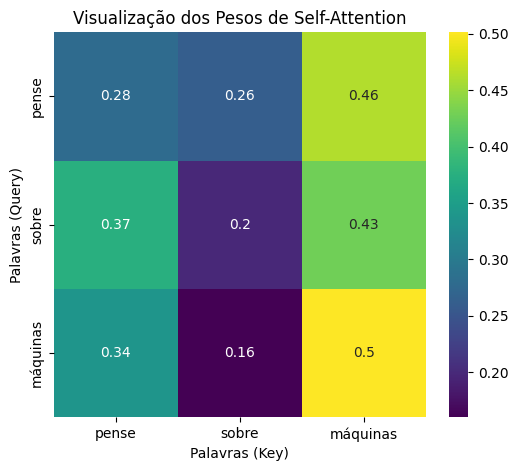

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sentence = ["pense", "sobre", "máquinas"]
plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights, xticklabels=sentence, yticklabels=sentence, annot=True, cmap="viridis")
plt.title("Visualização dos Pesos de Self-Attention")
plt.xlabel("Palavras (Key)")
plt.ylabel("Palavras (Query)")
plt.show()

**Análise:** A matriz de calor acima mostra a quem cada palavra "presta atenção" (incluindo ela mesma). A linha "pense" mostra os pesos que ela atribui a "pense", "sobre" e "máquinas" para criar sua nova representação.

## Parte 2: Transformers na Prática com Hugging Face

Construir um Transformer completo é complexo. Felizmente, a biblioteca `transformers` da Hugging Face nos dá acesso a milhares de modelos pré-treinados (como BERT, GPT, T5) com poucas linhas de código.

A arquitetura completa de um Transformer inclui:
- **Multi-Head Attention**: Fazer o Self-Attention várias vezes em paralelo, com diferentes matrizes de pesos, para capturar diferentes tipos de relações.
- **Positional Encodings**: Como não há recorrência, injetamos informações sobre a posição das palavras nos embeddings.
- **Feed-Forward Networks**: Camadas densas aplicadas a cada posição.
- **Encoder-Decoder Stacks**: Múltiplas camadas de encoder e/ou decoder empilhadas.

Vamos usar um pipeline para uma tarefa simples: análise de sentimentos.

In [17]:
# Descomente e execute se não tiver a biblioteca instalada
# !pip install transformers torch

from transformers import pipeline

# Carregando um pipeline pré-treinado para análise de sentimentos
# Este modelo foi treinado em um dataset em inglês.
sentiment_pipeline = pipeline("sentiment-analysis")

print("\n--- Análise de Sentimentos ---")
print("Frase: 'I love this new movie, it's fantastic!'")
print("Resultado:", sentiment_pipeline("I love this new movie, it's fantastic!"))

print("\nFrase: 'The service was terrible from start to finish.'")
print("Resultado:", sentiment_pipeline("The service was terrible from start to finish."))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu



--- Análise de Sentimentos ---
Frase: 'I love this new movie, it's fantastic!'
Resultado: [{'label': 'POSITIVE', 'score': 0.9998769760131836}]

Frase: 'The service was terrible from start to finish.'
Resultado: [{'label': 'NEGATIVE', 'score': 0.999686598777771}]


Vamos dar um passo além e visualizar os pesos de atenção de um modelo BERT real para entender como ele "pensa".

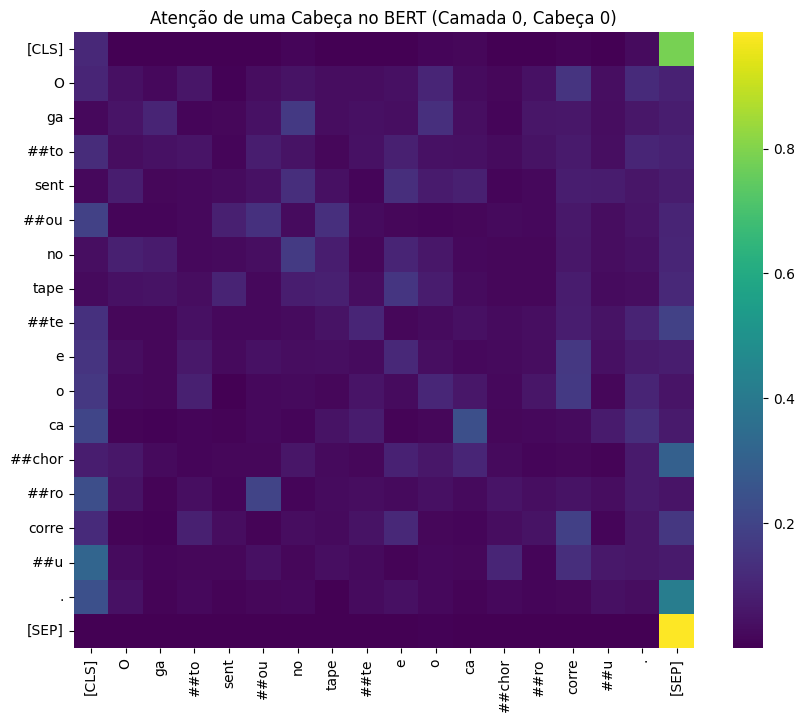

In [18]:

from transformers import AutoTokenizer, AutoModel
import torch

# Usaremos um BERT multilingual para podermos usar uma frase em português
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Frase de exemplo
sentence_pt = "O gato sentou no tapete e o cachorro correu."
inputs = tokenizer(sentence_pt, return_tensors="pt")
outputs = model(**inputs)

# 'outputs.attentions' é uma tupla com os pesos de atenção de cada camada (12 no BERT-base)
# Cada tensor tem o formato: [batch_size, num_heads, sequence_length, sequence_length]
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Vamos visualizar a atenção de uma cabeça específica (ex: cabeça 0) na primeira camada (camada 0)
attention_head_0 = attention[0][0, 0, :, :].detach().numpy()

# Plotando a matriz de atenção
plt.figure(figsize=(10, 8))
sns.heatmap(attention_head_0, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Atenção de uma Cabeça no BERT (Camada 0, Cabeça 0)")
plt.show()



**Análise:** Inspecione o mapa de calor. Note os pesos altos na diagonal (cada palavra presta atenção a si mesma) e em tokens especiais como `[CLS]` e `[SEP]`. Observe como "cachorro" pode estar prestando mais atenção em "correu", enquanto "gato" presta mais atenção em "sentou", capturando as relações de contexto da frase. Cada uma das 144 cabeças de atenção do BERT (12 camadas x 12 cabeças) aprende a focar em um tipo diferente de relação sintática ou semântica.

### Conclusão

Neste notebook, desvendamos o mecanismo de **Self-Attention**, o componente que tornou os Transformers possíveis e mudou o cenário da IA.

**Principais aprendizados:**
1.  **Atenção é Contexto:** O Self-Attention permite que um modelo pese a importância de diferentes palavras em uma sequência para construir representações ricas em contexto.
2.  **Paralelismo é Poder:** Ao eliminar a necessidade de processamento sequencial das RNNs, os Transformers podem ser treinados em conjuntos de dados muito maiores e em hardware moderno (GPUs/TPUs) de forma muito mais eficiente.
3.  **Modelos de Fundação:** A arquitetura Transformer é a base para quase todos os modelos de linguagem de ponta hoje, incluindo o BERT (focado em entendimento) e a família GPT (focada em geração), que impulsionam aplicações como a que você está usando agora.